# 1. SQL Task

**Write a query to get the ratio of type 1 to type 2 products per venue for just the year 2022.**

# Answer 1:
```sql
SELECT 
    venue_id, -- selecting unique identifier for venue
    SUM(CASE WHEN product_type = 'Type 1' THEN 1 ELSE 0 END) AS type1_count, -- count for type 1
    SUM(CASE WHEN product_type = 'Type 2' THEN 1 ELSE 0 END) AS type2_count, -- count for type 2...
    (SUM(CASE WHEN product_type = 'Type 1' THEN 1.0 ELSE 0 END) / 
     NULLIF(SUM(CASE WHEN product_type = 'Type 2' THEN 1 ELSE 0 END), 0)) AS ratio -- return NULL if no type_2 products (would cause error, divsion by zero)
FROM 
    products
WHERE 
    YEAR(timestamp) = 2022 -- year of interest
GROUP BY 
    venue_id; -- group by venue!
```

# 2. Exploratory Data Analysis

**One of the most important aspects of our business is the orders data, as it provides insight into what our customers want and how they interact with our machines. Provide a short exploratory data analysis. Assume that the attached CSV file is the dataset you prepared to answer these questions. Use your favourite Python libraries to do so and present your analysis in a Jupyter notebook.**

# Answer 2:

The following data contains 1,563 entries of purchases from a Martee Micromarket 001 device in Greenwich Expressway. 

In [1]:
# !pip install -r requirements.txt

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
pd.options.mode.chained_assignment = None  # default='warn'

# Load the dataset
data = pd.read_csv('expressway_historical.csv')

In [3]:
data_drop_dup = data.drop_duplicates()
print("Dropped", len(data) - len(data_drop_dup), "Duplicates.")

Dropped 2 Duplicates.


In [4]:
# Check for missing values
missing_values = data_drop_dup.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values

voucherCode       1496
errorMessage      1561
itemTagId         1561
promotion.id       541
promotion.name     541
promotion         1561
dtype: int64

Some missing values for presumably where a promotion or voucher was not used, hence no values for these.

To keep the columns of interest:

In [5]:
df = data_drop_dup[['timestamp', 'vendStatus', 'price',  # time and price 
       'discountValue', 'costPrice', 'vatRate', 'totalPaid', 'netAmount',    # various price and cost variables
       'vatAmount', 'voucherCode', 'isRefunded', 'product.name', 'promotion.name']]  # refund and product info

In [6]:
df[df.duplicated(keep=False)].head()

,timestamp,vendStatus,price,discountValue,costPrice,vatRate,totalPaid,netAmount,vatAmount,voucherCode,isRefunded,product.name,promotion.name
2,2023-07-22T20:00:26.049603,Payment Declined,2.95,0.0,1.64,0.2,2.95,2.46,0.49,NaN,False,Lo Bros - Raspberry & Lemon Kombucha,Banner 20% off
3,2023-07-22T20:00:03.774868,Success,4.50,0.0,2.49,0.0,4.50,4.50,0.00,NaN,False,Chicken & Bacon Caesar Wrap,Banner 20% off
4,2023-07-22T19:08:06.658216,Success,2.90,0.0,1.39,0.2,2.90,2.42,0.48,NaN,False,Grind - Iced Black Coffee,Banner 20% off
5,2023-07-22T19:01:33.638043,Success,1.50,0.0,0.42,0.2,1.50,1.25,0.25,NaN,False,Diet Coke,Banner 20% off
6,2023-07-22T18:00:57.047860,Success,1.25,0.0,0.49,0.2,1.25,1.04,0.21,NaN,False,Love Corn Pouch - Sea Salt,Banner 20% off


NOTE: There seems to be duplicate rows in the dataframe. We will assume that these corrrelate to someone buying two of the same product at the same time, rather than being an error. Clarification needed on this point.

If they are simply duplicates, they should be removed from analysis.

# Analysis: Summary Statistics

- Items' selling prices range from £0.15 to £6.20, with a mean price of £2.99. 

- **The mean discount is about 20p**, meaning the mean price paid is £2.79. The discounts range from £3.10 to minus figures -£0.64. This presumably comes from meal deals that are composed of items that actually cost less on their own, and only occurs in 2 meal deal orders across the data. 

- The profitLoss column was made by subtracting Cost from netAmount (which is the total paid minus VAT). This shows that some losses can be made up to 83p, but profits of up to £3.20 are also possible.

- ***VAT is either 20%, or 0%.** It can be up to 65p, with a mean of 20p per item sold. We can look into the effect of VAT-eligible items versus non-VAT in our analysis, to see how VAT affects final earnings.

- Most items sold have a promotion applied, almost one third, at 65%.


In [7]:
print("The data ranges from", df['timestamp'].min(), "to", df['timestamp'].max())
print(" i.e., the end of June to end of August 2023")

The data ranges from 2023-06-26T08:22:03.520502 to 2023-08-28T18:04:54.617042
 i.e., the end of June to end of August 2023


In [8]:
print(round(100-(df['promotion.name'].isna().sum() / len(df))*100, 2),"% of items have a promotion applied" )

65.34 % of items have a promotion applied


In [9]:
# Create PL column
df['profitLoss'] = df['netAmount'] - df['costPrice']
# generate summary statistics
df.describe()

,price,discountValue,costPrice,vatRate,totalPaid,netAmount,vatAmount,profitLoss
count,1561.000000,1561.000000,1561.000000,1561.000000,1561.000000,1561.000000,1561.000000,1561.000000
mean,2.990474,0.191384,1.456176,0.118258,2.799090,2.591813,0.202896,1.135637
std,1.318949,0.483940,0.902877,0.098351,1.248059,1.338068,0.190080,0.711305
min,0.150000,-0.640000,0.000000,0.000000,0.150000,0.130000,0.000000,-0.830000
25%,1.800000,0.000000,0.650000,0.000000,1.800000,1.500000,0.000000,0.680000
50%,2.900000,0.000000,1.400000,0.200000,2.840000,2.420000,0.250000,0.980000
75%,3.500000,0.000000,1.950000,0.200000,3.250000,3.250000,0.350000,1.500000
max,6.200000,3.100000,4.650000,0.200000,6.200000,6.200000,0.650000,3.200000


# Customer Behaviour

1. Vend Status: **Almost 20% of the vendings have payment declined**, which seems like a very high number for a low-cost vending machine. We should inspect payment methods and see why this is happening (AmEx not accepted? Phone NFC payments or Smart Watch?)

2. **The most commonly sold items are Chicken & Bacon Caesar Wrap, Diet Coke and Chicken Chipotle Wrap**. There are 73 items in total, but only 8 of them were sold more than 40 times, and the most popular item (Chicken & BAcon Caesar Wrap) is the only one sold over 100 times. But what about the profit margins?

3. When it comes to profit per item, **Nigella Chickpea Ricebox is top, with £2.66 earned per item sold.**

In [10]:
# how often are transactions declined?
df['vendStatus'].value_counts()

vendStatus
Success             1278
Payment Declined     283
Name: count, dtype: int64

In [11]:
print("There are", len(df['product.name'].unique()), "unique products in the machines sold in this time period.")

There are 73 unique products in the machines sold in this time period.


In [12]:
# Create a df with only successful transactions
df_sales = df[df['vendStatus']=='Success']

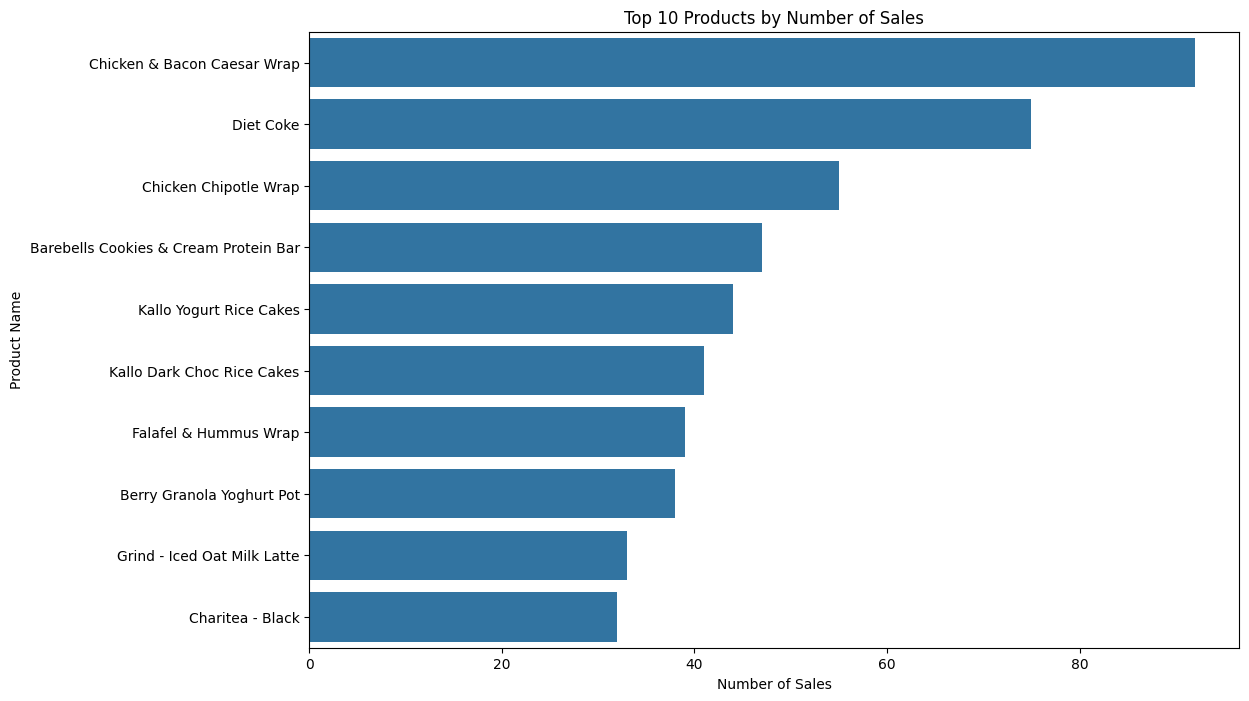

In [13]:
# Top 10 products by number of sales
top_products = df_sales['product.name'].value_counts().head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Products by Number of Sales')
plt.xlabel('Number of Sales')
plt.ylabel('Product Name')
plt.show()

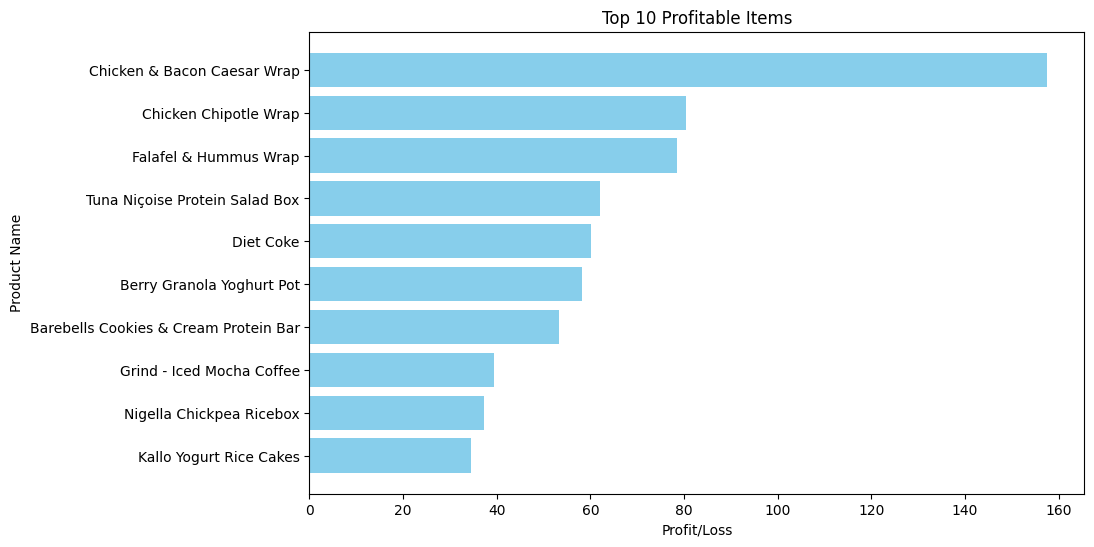

In [14]:
profitable_items = df_sales.groupby('product.name')['profitLoss'].sum().sort_values(ascending=False)

# Get the top 10 items
top_10_items_profit = profitable_items.head(10)

# Create a bar plot
plt.figure(figsize=(10,6))
plt.barh(top_10_items_profit.index, top_10_items_profit.values, color='skyblue')
plt.xlabel('Profit/Loss')
plt.ylabel('Product Name')
plt.title('Top 10 Profitable Items')
plt.gca().invert_yaxis()  # invert the y-axis to have the item with the highest profit at the top
plt.show()


In [15]:
# These items earn the most profit per sale
average_profit_per_item = df_sales.groupby('product.name')['profitLoss'].mean()
average_profit_per_item.sort_values(ascending=False).head(10)

product.name
Nigella Chickpea Ricebox                      2.668571
Grind - Iced Mocha Coffee                     2.628000
Tuna Niçoise Protein Salad Box                2.389231
Spinach, Butternut & Lentil Hotpot            2.290000
Spinach & Paneer Curry Hotpot                 2.290000
Lo Bros - Passionfruit Kombucha               2.095000
Perfect Ted - Matcha Apple Raspberry Drink    2.089231
Chicken Tabbouleh Salad                       2.012500
Falafel & Hummus Wrap                         2.011538
Antipasti Pesto Pasta Salad                   1.990000
Name: profitLoss, dtype: float64

In [16]:
df.columns

Index(['timestamp', 'vendStatus', 'price', 'discountValue', 'costPrice',
       'vatRate', 'totalPaid', 'netAmount', 'vatAmount', 'voucherCode',
       'isRefunded', 'product.name', 'promotion.name', 'profitLoss'],
      dtype='object')

# Effect of Promotions on Sales

- **The 20% off promo is the most common** by far, followed by the Healthy Meal Deal, and a smattering of the others.

- Some of the best selling products from above get **lots of their uplift from promotions** , including the Chicken & Bacon Caesar Wrap, our best seller.

- The graph below shows the proportion of each product with their promotions. **All the big sellers are much more commonly sold in a promotion**.

- Interestingly, **the 20% off promo generates the most profit on average of all promos, with a mean £1.27 profit** per item sold, while the Healthy Meal Deal only generates 61p per item on average. Also, the 50% off promotion, though only 30 have happened, generated 78p in profit per item sold. Perhaps we should be pushing this over the Healthy Meal Deal. 

- The **Fresh Meal Discount leads to losses of 32p and 64p** for lunch and breakfast, respectively. 

- In total, promoted items earned £400+ more in profit than non-promoted items, but only 38 of the 73 total items performed better when part of promotions.

In [17]:
df_sales['promotion.name'].value_counts()

promotion.name
Banner 20% off                     600
Healthy Meal Deal                  231
Banner 50% off                      30
Fresh Meal Discount - Lunch          5
Fresh Meal Discount - Breakfast      2
Name: count, dtype: int64

In [18]:
# Calculate total sales for promoted and non-promoted products
total_sales_promoted = df_sales[df_sales['promotion.name'].notna()].groupby('product.name')['totalPaid'].sum()
total_sales_non_promoted = df_sales[df_sales['promotion.name'].isna()].groupby('product.name')['totalPaid'].sum()

# Calculate sales uplift
sales_uplift = total_sales_promoted - total_sales_non_promoted
sales_uplift.sort_values(ascending=False).head(10)

product.name
Chicken & Bacon Caesar Wrap            197.67
Tuna Niçoise Protein Salad Box         119.17
Falafel & Hummus Wrap                  117.69
Falafel Vitality Mezze Salad            77.83
Brite Focus Drink - Pineapple Mango     71.92
Chicken Chipotle Wrap                   54.05
Charitea - Black                        47.98
Diet Coke                               47.21
Chipotle Corn & Avocado Healthpot       46.88
Berry Granola Yoghurt Pot               38.35
Name: totalPaid, dtype: float64

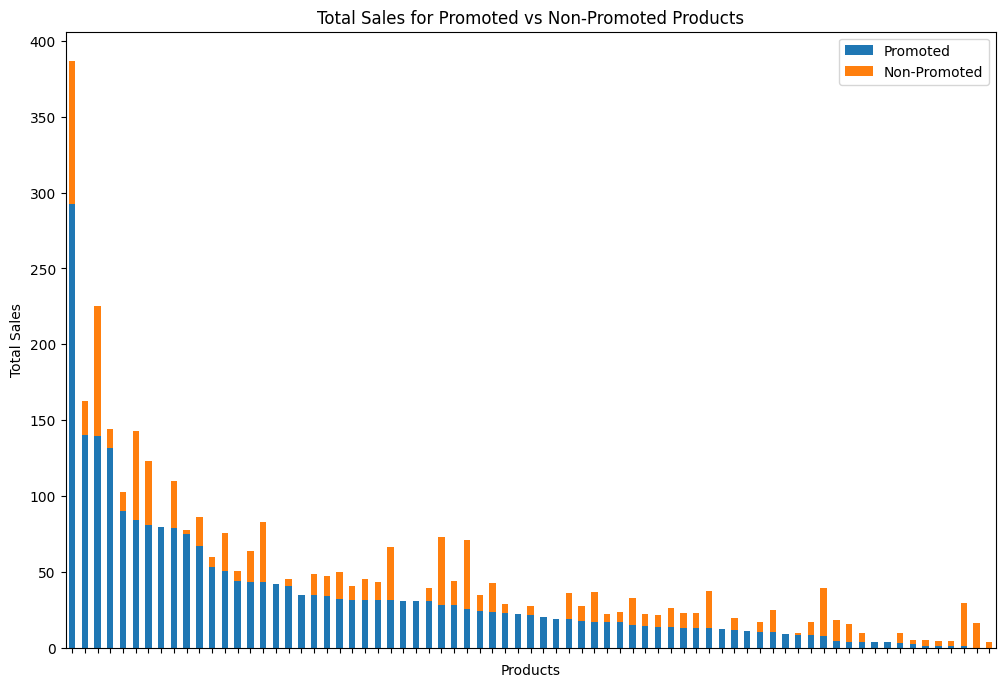

In [19]:
# Sort the DataFrame by the 'Promoted' column
plot_data = pd.DataFrame({'Promoted': total_sales_promoted, 'Non-Promoted': total_sales_non_promoted})
plot_data = plot_data.sort_values(by='Promoted', ascending=False)

# Create the plot
ax = plot_data.plot(kind='bar', stacked=True, figsize=(12, 8))
ax.set_xticklabels('')  # Hide x-axis labels
plt.title('Total Sales for Promoted vs Non-Promoted Products')
plt.xlabel('Products')
plt.ylabel('Total Sales')
plt.show()

In [20]:
# Profit earned per item per promotion on average
average_profit_per_promotion = df.groupby('promotion.name')['profitLoss'].mean()
average_profit_per_promotion.sort_values(ascending=False)

promotion.name
Banner 20% off                     1.269903
Banner 50% off                     0.775937
Healthy Meal Deal                  0.614559
Fresh Meal Discount - Lunch       -0.342857
Fresh Meal Discount - Breakfast   -0.620000
Name: profitLoss, dtype: float64

In [21]:
# Observe if profit increases for promoted items or not

# Calculate profitLoss when part of a promotion
total_paid_promoted = df_sales[df_sales['promotion.name'].notna()].groupby('product.name')['profitLoss'].sum()

# Calculate profitLoss when not part of a promotion
total_paid_non_promoted = df_sales[df_sales['promotion.name'].isna()].groupby('product.name')['profitLoss'].sum()
total_paid_non_promoted.fillna(0)

# Create a DataFrame to compare the results
comparison_df = pd.DataFrame({'Promoted': total_paid_promoted, 'Non-Promoted': total_paid_non_promoted})

# See when the promoted product performs better
comparison_df['Difference'] = comparison_df['Promoted'] - comparison_df['Non-Promoted']

# Create a column indicating whether the promoted product earned more
comparison_df['Promoted Earned More'] = np.where(comparison_df['Difference'] > 0, True, False)
comparison_df

,Promoted,Non-Promoted,Difference,Promoted Earned More
product.name,,,,
Antipasti Pesto Pasta Salad,13.93,NaN,NaN,False
Avocado & Edamame Healthpot,4.55,NaN,NaN,False
Avocado & Goji Berry Bagel,3.98,3.00,0.98,True
Barebells Caramel & Cashew Protein Bar,4.39,25.34,-20.95,False
Barebells Cookies & Cream Protein Bar,29.80,23.58,6.22,True
...,...,...,...,...
The Gut Stuff Cocoa & Hazelnut Bar,5.64,4.89,0.75,True
The Protein Ball Co - Peanut Butter,14.14,6.05,8.09,True
Tribe Active Oats Pot - Raspberry Nut Crunch,8.18,5.19,2.99,True


In [22]:
print("In total, promoted products earned £", round(comparison_df.Promoted.sum() - comparison_df['Non-Promoted'].sum()), "more than unpromoted products.")
print("However, only", comparison_df['Promoted Earned More'].sum(), "of the 73 total items earned more profit on promotions in total, so these specific items should be priotised for promotion. The other items should be considered, as they generate more profit when not part of a promotion")

In total, promoted products earned £ 428 more than unpromoted products.
However, only 38 of the 73 total items earned more profit on promotions in total, so these specific items should be priotised for promotion. The other items should be considered, as they generate more profit when not part of a promotion


# Time of Day and Week 

- Below we can see that sales drop on weekend days, with peaks often on Tuesday and Thursdays.

- We can also see a peak in the time of day, that purchases occur around 12 noon and 3pm. 

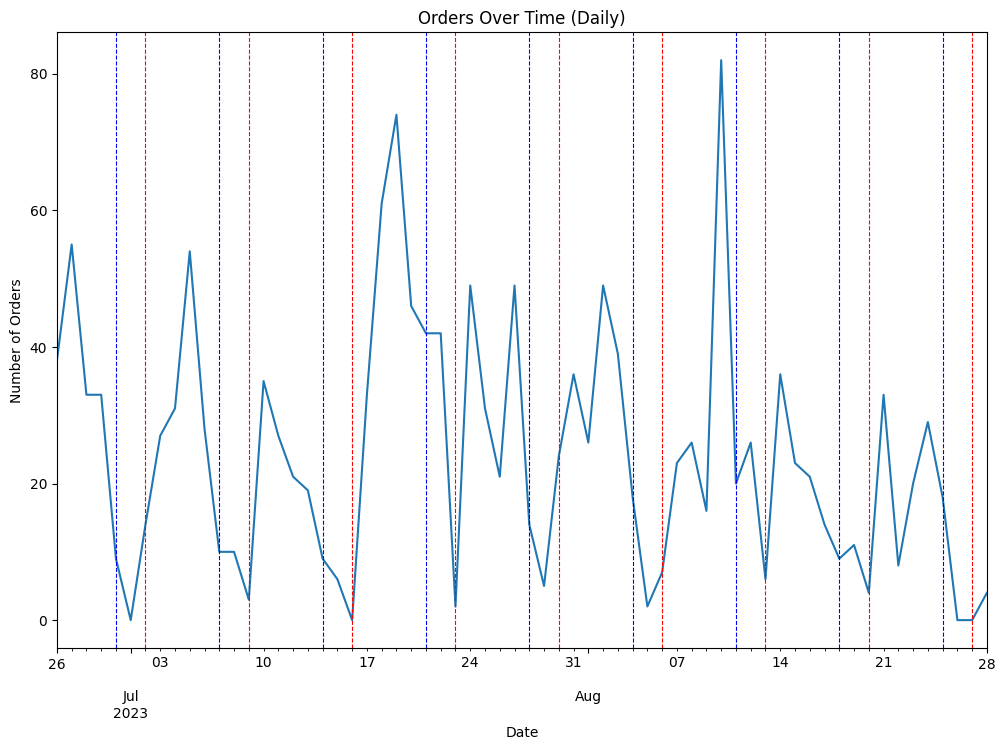

In [23]:
# Create a copy of the DataFrame
df_copy = df.copy()

# Convert the 'timestamp' column to datetime
df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])

# Set the 'timestamp' column as the index
df_copy.set_index('timestamp', inplace=True)

# Resample the data by day
orders_over_time_daily = df_copy.resample('D').size()

# Plot the orders over time by day
plt.figure(figsize=(12, 8))
orders_over_time_daily.plot()

# Add vertical lines to indicate the beginning of each week (Monday)
for week_start in pd.date_range(start=orders_over_time_daily.index.min(), 
                  end=orders_over_time_daily.index.max(), 
                       freq='W-SUN'):
    plt.axvline(x=week_start, color='red', linestyle='--', linewidth=0.8)

# Add vertical lines to indicate the beginning of each weekend (Saturday)
for weekend_start in pd.date_range(start=orders_over_time_daily.index.min(), 
                  end=orders_over_time_daily.index.max(), 
                       freq='W-FRI'):
    plt.axvline(x=weekend_start, color='blue', linestyle='--', linewidth=0.8)

plt.title('Orders Over Time (Daily)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()


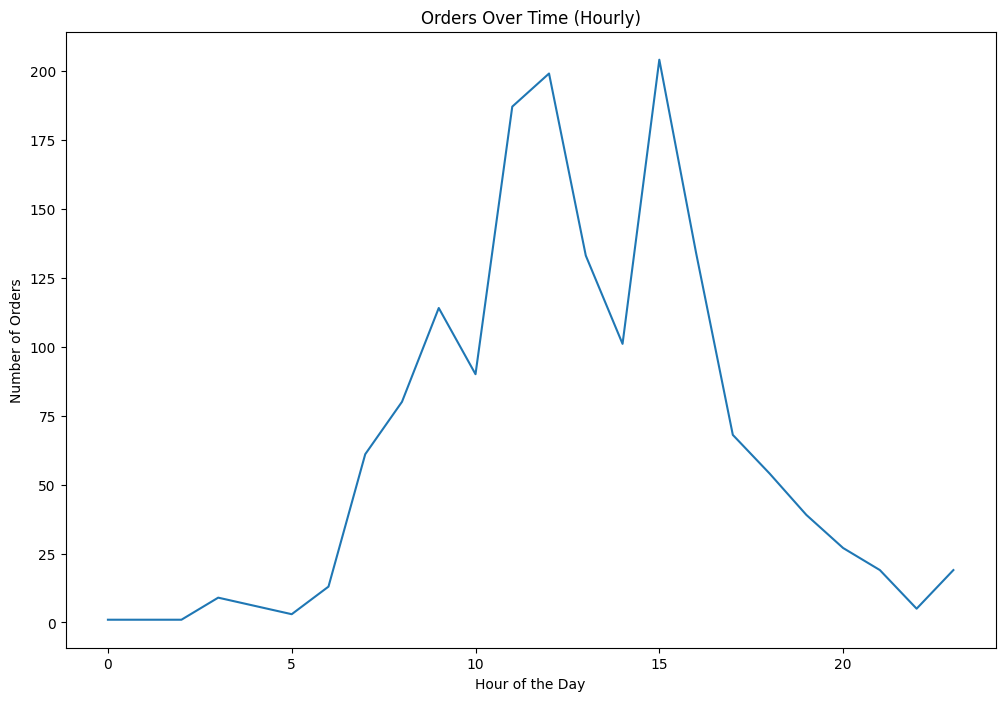

In [24]:
# Create a copy of the DataFrame
df_copy = df.copy()

# Convert the 'timestamp' column to datetime
df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])

# Extract the hour from the timestamp
df_copy['hour'] = df_copy['timestamp'].dt.hour

# Group by the hour to get the number of orders for each hour
orders_over_time_hourly = df_copy.groupby('hour').size()

# Plot the orders over time by hour
plt.figure(figsize=(12, 8))
orders_over_time_hourly.plot()

plt.title('Orders Over Time (Hourly)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.show()


# Extra considerations:

- With more time, one could consider the effect of meals being part of the healthy meal deal or doing better when sold individually.

- Also, the effect of VAT could be investigated. Is it cannibalizing profits? Should we aim for non-VAT products?

- Voucher codes could be looked at for effectiveness and effect on profits


# Stats Challenge 

*The venue where this machine is wants to know if the total spend for breakfast is higher than snacks or lunch. Based on the time of the orders, perform a hypothesis test and provide feedback to the venue.*

- H0: The total spend on breakfast is not higher than snacks or lunch. 

- H1: The total spend on breakfast is significantly higher than snacks or lunch.

Our assumptions here is that breakfast is bought between 5am and 11am, lunch is items sold between 11 and 3pm, and the rest of the day's items are snacks. We will set a level of significance at p = 0.05. Any values below this mean we can reject the null hypothesis.

In [25]:
def assign_meal_type(row):
    if 5 <= row.hour < 11:  # if the order was made between 5am and 11am
        return 'Breakfast'
    elif 11 <= row.hour < 15:  # if the order was made between 11am and 3pm
        return 'Lunch'
    else:  # if the order was made at any other time
        return 'Snack'

df_sales['timestamp'] = pd.to_datetime(df_sales['timestamp'])

df_sales['meal_type'] = df_sales['timestamp'].apply(assign_meal_type)


In [26]:
total_paid_per_meal_type = df_sales.groupby('meal_type')['totalPaid'].sum()
total_paid_per_meal_type

meal_type
Breakfast     823.52
Lunch        1530.67
Snack        1190.24
Name: totalPaid, dtype: float64

In [27]:

# Perform an ANOVA test
f_val, p_val = stats.f_oneway(df_sales[df_sales['meal_type'] == 'Breakfast']['totalPaid'],
                              df_sales[df_sales['meal_type'] == 'Snack']['totalPaid'],
                              df_sales[df_sales['meal_type'] == 'Lunch']['totalPaid'])

print('F-value:', f_val)
print('p-value:', p_val)


F-value: 21.338439296664404
p-value: 7.665718216891724e-10


# Stats Result

The ANOVA (Analysis of Variance) test was used to determine if there are significant differences in the total spend for breakfast, snacks, and lunch. The null hypothesis for an ANOVA test is that there's no difference in the means of the groups being compared. This will be our proxy for the total spend being larger or smaller. The p-value was far less than 0.05, at 5.79e-06. This means we can reject the null hypothesis and conclude that there is a difference in the total spend for breakfast items versus lunch and snacks. However, it is that breakfast is the lower spend, as we can see from the above raw numbers. Breakfast spend was £823, while lunch £1531 and snacks £1190. 

We could already see from our raw numbers that Breakfast total spend was less in total than that of snacks and lunch, respectively. So the hypothesis test actually shows that there is a significant difference between the total spend for breakfast items, but it's actually that breakfast is significantly lower than that of the other two groups. 

# Machine Learning

*The most important thing to predict is demand for products. Apply machine learning techniques to produce a model that can predict overall demand (as sales).*

### Feature Engineering:

Create time of day by hour and categories, and weekday vs weekend columns. (Should we need it...)

In [28]:
# Convert the 'timestamp' column to datetime if it's not already
df_sales.loc[:, 'timestamp'] = pd.to_datetime(df_sales['timestamp'])

# Create the 'hour_of_day' feature
df_sales.loc[:, 'hour_of_day'] = df_sales['timestamp'].dt.hour

def assign_time_of_day(hour):
    if 5 <= hour < 12:  # if the order was made between 5am and 12pm
        return 'Morning'
    elif 12 <= hour < 17:  # if the order was made between 12pm and 5pm
        return 'Noon'
    else:  # if the order was made at any other time
        return 'Evening'

df_sales.loc[:, 'time_of_day'] = df_sales['hour_of_day'].apply(assign_time_of_day)

# Create the 'weekday_weekend' feature
df_sales.loc[:, 'weekday_weekend'] = df_sales['timestamp'].dt.weekday.apply(lambda x: 'Weekday' if x < 5 else 'Weekend')


### Model training:

Using simple ARIMA. No use for SARIMA as we can't see seasonality over just two months data.

In [29]:

df_ts = df.copy() 

# Set the 'timestamp' column as the index
df_ts.set_index('timestamp', inplace=True)
# Convert the index to datetime
df_ts.index = pd.to_datetime(df_ts.index)



In [30]:
# Resample the data by day and calculate total sales for each day
daily_sales = df_ts.resample('D')['totalPaid'].sum()

# Fit an ARIMA model
model = ARIMA(daily_sales, order=(2,1,5))
model_fit = model.fit()

# Make predictions for the next 30 days
forecast_result = model_fit.forecast(steps=30)

# The forecast, standard error, and confidence interval are stored in forecast_result
forecast = forecast_result.iloc[0]
stderr = forecast_result.iloc[1]
conf_int = forecast_result.iloc[2]


/Users/ciaryan3/opt/anaconda3/envs/hwenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


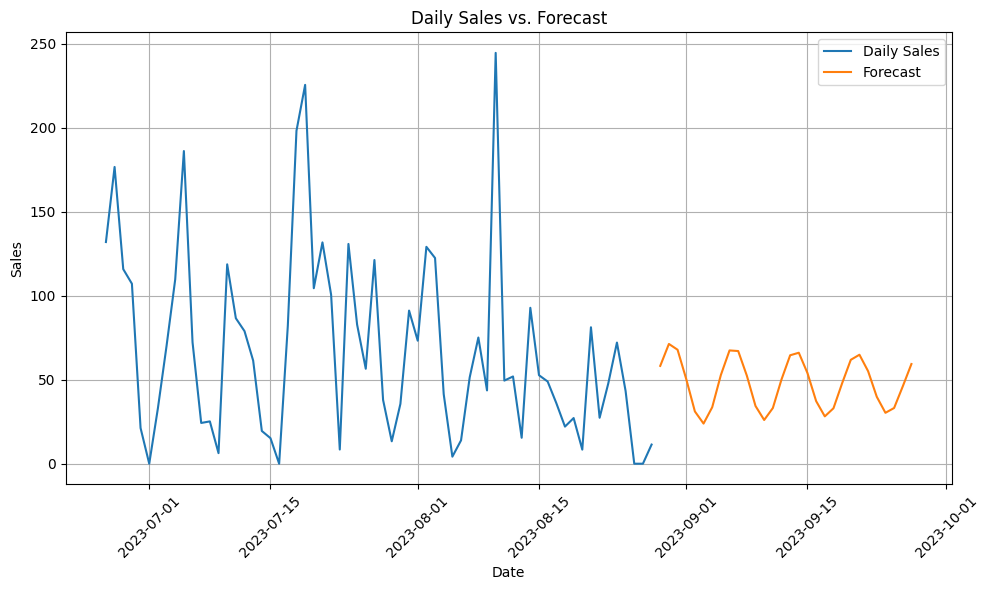

In [31]:
# Assuming your series are pandas Series with dates as index
plt.figure(figsize=(10, 6))  # Set figure size

# Plot daily sales
plt.plot(daily_sales.index, daily_sales.values, label='Daily Sales')

# Plot forecast results
plt.plot(forecast_result.index, forecast_result.values, label='Forecast')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Sales vs. Forecast')

# Add legend
plt.legend()

# Rotate x-axis labels for better readability if many dates
plt.xticks(rotation=45)

# Show the plot
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Adjust spacing between elements
plt.show()


# Stepwise auto-ARIMA

Slightly more advanced version to see what AutoARIMA can come up with.

ADF Statistic: -5.272791042360505
p-value: 6.232863654997064e-06
Critical Values:
   1%: -3.5386953618719676
   5%: -2.9086446751210775
   10%: -2.591896782564878
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=697.609, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=701.706, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=691.892, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=694.801, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=757.498, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=694.084, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=683.473, Time=0.15 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=686.900, Time=0.29 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=686.406, Time=0.17 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=688.023, Time=0.11 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=684.508, Time=0.20 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=684.850, Time=0.22 sec
 ARIMA(0,0,1)(

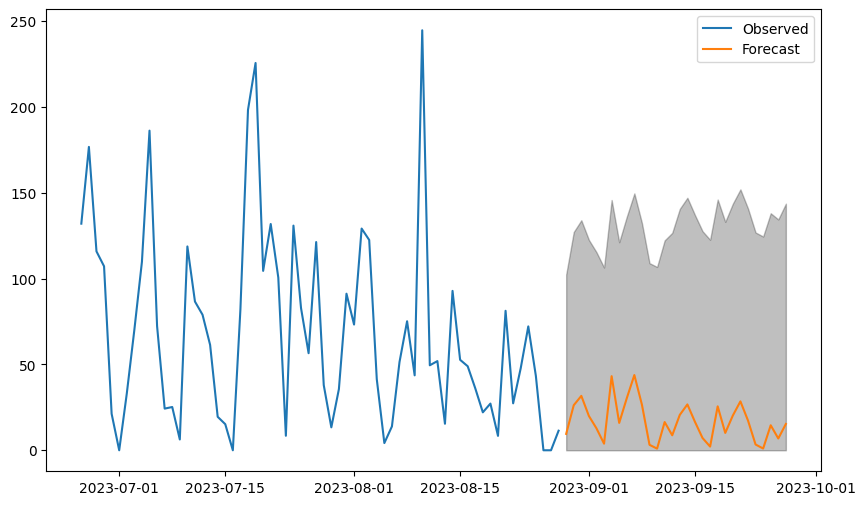

In [32]:
# Check for stationarity and apply differencing if necessary
# (You can use ADF test to check for stationarity)

result = adfuller(daily_sales)
# Extract and print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

if result[1] > 0.05:
    daily_sales_diff = daily_sales.diff().dropna()
else:
    daily_sales_diff = daily_sales

# Use auto_arima to find the best parameters
auto_model = auto_arima(daily_sales_diff, seasonal=True, m=7, trace=True, error_action='ignore', suppress_warnings=True)
print(auto_model.summary())

# Fit the SARIMA model
model = SARIMAX(daily_sales, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
model_fit = model.fit(disp=False)

# Make predictions for the next 30 days
forecast_result = model_fit.get_forecast(steps=30)
forecast_conf_int = forecast_result.conf_int()

forecast_conf_int.iloc[:, 0] = forecast_conf_int.iloc[:, 0].clip(lower=0) # Ensure it can't be less than zero

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(daily_sales, label='Observed')
plt.plot(forecast_result.predicted_mean, label='Forecast')
plt.fill_between(forecast_conf_int.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], color='k', alpha=.25)
plt.legend()
plt.show()


Explanation:

1. Stationarity Check: The Augmented Dickey-Fuller (ADF) test is used to check if the time series is stationary. If the p-value is greater than 0.05, the series is not stationary, and differencing is applied.

2. Auto ARIMA: The auto_arima function from the pmdarima library is used to find the best parameters for the ARIMA model, including seasonal components.

3. SARIMA Model: The SARIMAX model from statsmodels is used to fit the data with the parameters obtained from auto_arima.

4. Forecasting and Visualization: The forecast for the next 30 days is made, and the results are plotted along with confidence intervals.

Naturally we don't have enough data to accurately predict a month in advance. This data doesn't feature more than two months of info. The model is predicting a fall-off, likely due to the drop in purchases in August. But the restart of the School year and countless other factors would come into play here. Two months data simply isn't enough to forecast this type of seasonality.
